# A very simple chord recognition convnet

We're gonna use synthesize data and use CQT as representation. 

In [36]:
%matplotlib inline
import numpy as np
import librosa
import keras
import keras.backend as K
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings('ignore')

### Utility function to generate data

In [20]:
def sin_wave(secs, freq, sr, gain):
    '''
    Generates a sine wave of frequency given by freq, with duration of secs.
    '''
    t = np.arange(sr * secs)
    return gain * np.sin(2 * np.pi * freq * t / sr)


def whitenoise(gain, shape):
    '''
    Generates white noise of duration given by secs
    '''
    return gain * np.random.uniform(-1., 1., shape)

def chord_wave(secs, f0, sr, gain, major):
    """major: bool"""
    t = np.arange(sr * secs)
    sine_f0 = gain * np.sin(2 * np.pi * f0 * t / sr)
    if major:
        sine_third = gain * np.sin(2 * np.pi * f0 * 2. ** (4./12.) * t / sr)
    else:
        sine_third = gain * np.sin(2 * np.pi * f0 * 2. ** (3./12.) * t / sr)
    return sine_f0 + sine_third

In [30]:
def add_channel_axis(cqt):
    if K.image_data_format == 'channels_first':
        return cqt[np.newaxis, :, :]
    else:
        return cqt[:, :, np.newaxis]

In [67]:
class DataGen:
    def __init__(self, sr=16000, batch_size=128):
        np.random.seed(1209)
        self.pitches = [440., 466.2, 493.8, 523.3, 554.4, 587.3,
                        622.3, 659.3, 698.5, 740., 784.0, 830.6]

        self.sr = sr
        self.n_class = 2 # major or minor
        self.secs = 1.
        self.batch_size = batch_size
        self.labels = np.eye(self.n_class)[range(0, self.n_class)]  # 1-hot-vectors
    
        self.major_cqts = []
        self.minor_cqts = []
        
        for freq in self.pitches:
            cqt = librosa.cqt(chord_wave(self.secs, freq, self.sr, gain=0.5, major=True), sr=sr,
                              fmin=220, n_bins=36, filter_scale=2)[:, 2:5]  # use three frames!
            cqt = librosa.amplitude_to_db(cqt, ref=np.min)
            cqt = cqt / np.max(cqt) # cqt in 2d
            
            self.major_cqts.append(add_channel_axis(cqt))
            
            cqt = librosa.cqt(chord_wave(self.secs, freq, self.sr, gain=0.5, major=False), sr=sr,
                              fmin=220, n_bins=36, filter_scale=2)[:, 2:5]  # use three frame!
            cqt = librosa.amplitude_to_db(cqt, ref=np.min)
            cqt = cqt / np.max(cqt)
            self.minor_cqts.append(add_channel_axis(cqt))

        self.cqt_shape = add_channel_axis(cqt).shape  # (1, 36, 3) or (36, 3, 1)

    def next(self): 
        """Yielding half Major, half minor"""
        choice = np.random.choice(12, size=self.batch_size // 2, # pick pitches for this batch
                                  replace=True)
        noise_gain = 0.1 * np.random.random_sample(1)  # a random noise gain 
        noise = whitenoise(noise_gain, self.cqt_shape)  # generate white noise
        xs = [noise + self.major_cqts[i] for i in choice]  # compose a batch with additive noise (Major)
        xs += [noise + self.minor_cqts[i] for i in choice]  # compose a batch with additive noise (minor)
        
        ys = np.eye(2)[np.hstack((np.zeros(self.batch_size // 2, dtype=np.int), 
                                  np.ones(self.batch_size // 2, dtype=np.int)))] # corresponding labels

        return np.array(xs, dtype=np.float32), np.array(ys, dtype=np.float32)

So, Major is labeled as [1, 0], and minor as [0, 1].

## Experiment

In [68]:
datagen = DataGen()
x, y = datagen.next()

### How does input data look like?

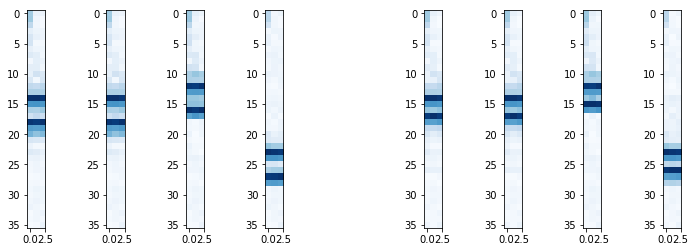

In [137]:
plt.figure(figsize=(14, 4))
if K.image_data_format == 'channels_first':
    for i in range(4):
        plt.subplot(1, 10, i+1)
        plt.imshow(x[i, 0], cmap=plt.get_cmap('Blues'))
        plt.subplot(1, 10, 6+i)
        plt.imshow(x[64 + i, 0], cmap=plt.get_cmap('Blues'))
else:
    for i in range(4):
        plt.subplot(1, 10, i+1)
        plt.imshow(x[i, :, :, 0], cmap=plt.get_cmap('Blues'))
        plt.subplot(1, 10, 6+i)
        plt.imshow(x[64 + i, :, :, 0], cmap=plt.get_cmap('Blues'))


(Major inputs on left, minor inputs on right.)

### Buld a convnet model!

In [70]:
val_datagen = DataGen() # this is a generator for validation set

* This convlayer takes `(36, 3)` with single channel input.
* The kernel size is (5, 3) so that it can cover the spectral patterns of major and minor chords.

In [138]:
# even a simplet network -- one conv layer and that's it!
# If you wanna try it. 


# model = keras.models.Sequential()
# model.add(keras.layers.convolutional.Conv2D(datagen.n_class, (5, 3), use_bias=False, padding='same',
#                              input_shape=datagen.cqt_shape)) # A conv2d layer (36 input nodes --> 8 output nodes)
# model.add(keras.layers.pooling.GlobalMaxPooling2D())
# model.add(keras.layers.Activation('softmax'))  # Softmax because it's single-label classification

# model.compile(optimizer=keras.optimizers.SGD(lr=0.01, momentum=0.9,  # a pretty standard optimizer
#                                              decay=1e-6, nesterov=True),
#               loss='categorical_crossentropy',  # categorical crossentropy makes sense with Softmax
#               metrics=['accuracy'])  # we'll also measure the performance but it's NOT a loss function  

In [112]:
np.random.seed(12345)
model = keras.models.Sequential()
model.add(keras.layers.convolutional.Conv2D(4, (5, 3), use_bias=False, padding='valid',
                             input_shape=datagen.cqt_shape)) # A conv2d layer (36 input nodes --> 8 output nodes)
model.add(keras.layers.pooling.GlobalMaxPooling2D())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.Dense(datagen.n_class, use_bias=False))
model.add(keras.layers.Activation('softmax'))

model.compile(optimizer=keras.optimizers.SGD(lr=0.01, momentum=0.9,  # a pretty standard optimizer
                                             decay=1e-6, nesterov=True),
              loss='categorical_crossentropy',  # categorical crossentropy makes sense with Softmax
              metrics=['accuracy'])  # we'll also measure the performance but it's NOT a loss function  

In [113]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 32, 1, 4)          60        
_________________________________________________________________
global_max_pooling2d_8 (Glob (None, 4)                 0         
_________________________________________________________________
activation_14 (Activation)   (None, 4)                 0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 8         
_________________________________________________________________
activation_15 (Activation)   (None, 2)                 0         
Total params: 68
Trainable params: 68
Non-trainable params: 0
_________________________________________________________________


### Train it!

In [114]:
history = model.fit_generator(datagen, steps_per_epoch=100, epochs=100, verbose=1,
                             validation_data=val_datagen, validation_steps=4)

Epoch 1/100
100/100 [==============================] - 0s - loss: 0.6721 - acc: 0.6387 - val_loss: 0.6343 - val_acc: 0.8848
Epoch 2/100
100/100 [==============================] - 0s - loss: 0.5633 - acc: 0.9861 - val_loss: 0.4704 - val_acc: 1.0000
Epoch 3/100
100/100 [==============================] - 0s - loss: 0.3370 - acc: 1.0000 - val_loss: 0.2179 - val_acc: 1.0000
Epoch 4/100
100/100 [==============================] - 0s - loss: 0.1508 - acc: 1.0000 - val_loss: 0.0970 - val_acc: 1.0000
Epoch 5/100
100/100 [==============================] - 0s - loss: 0.0759 - acc: 1.0000 - val_loss: 0.0566 - val_acc: 1.0000
Epoch 6/100
100/100 [==============================] - 0s - loss: 0.0462 - acc: 1.0000 - val_loss: 0.0387 - val_acc: 1.0000
Epoch 7/100
100/100 [==============================] - 0s - loss: 0.0317 - acc: 1.0000 - val_loss: 0.0256 - val_acc: 1.0000
Epoch 8/100
100/100 [==============================] - 0s - loss: 0.0245 - acc: 1.0000 - val_loss: 0.0230 - val_acc: 1.0000
Epoch 9/

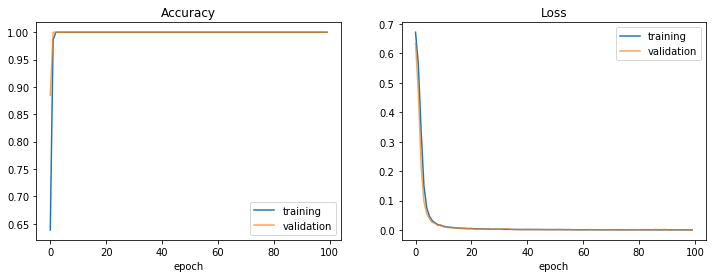

In [139]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['acc'], label='training')
plt.plot(history.history['val_acc'], label='validation', alpha=0.7)
plt.title('Accuracy')
plt.xlabel('epoch')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='validation', alpha=0.7)
plt.title('Loss')
plt.xlabel('epoch')
plt.legend()

In [116]:
loss = model.evaluate_generator(datagen, steps=10)
print("loss: {}, accuracy: {}".format(loss[0], loss[1]))

loss: 0.000586385658244, accuracy: 1.0


In [117]:
weights = model.get_weights()[0]
print("The Convolution2D layer weights shape is: {}".format(weights.shape))

The Convolution2D layer weights shape is: (5, 3, 1, 4)


, which is (height_kernel, width_kernel, input_channel_number, output_channel_number)

# Visualise the kernels

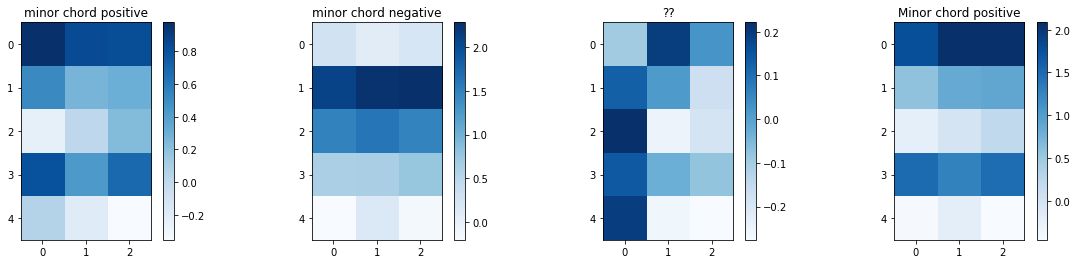

In [123]:
plt.figure(figsize=(20, 4))
titles = ['minor chord positive', 'minor chord negative', '??', 'Minor chord positive']
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(weights[:, :, 0, i], cmap=plt.get_cmap('Blues'))
    plt.colorbar()
    plt.title(titles[i])

In [122]:
dense_weights = model.get_weights()[1]
print(dense_weights)

[[-0.49604255  2.32967782]
 [ 2.91612864 -3.8794291 ]
 [-0.61364514 -0.32284012]
 [-3.05433393  3.24701381]]


Look at the dense layer weights! Each row-->input, each column-->output. 

1. The 1st feature map will have an high activation on minor chords. 
  - After global maxpooling, this feature map will have large value on minor chord input, and small value on Major chord input. 
  - The value is multiplied to `-0.496` on the Major output node, and `2.33` on the minor output node. 
  - Seems alright, huh?

2. The 2nd feature map will have a large negative activation on minor chord.

3. Not sure what this kernel is doing. `[-0.6, -0.3]` weights also say this kernel is not too crucial.

4. The 4th is minor chord positive. `[-3.05, 3.25` supports it again.